In [2]:
import time
import requests
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import json
from rdflib import Graph

from upsetplot import generate_counts, from_contents, generate_samples, UpSet, plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

In [5]:

def get_biotools_rsec_urls():  
    rsec_urls = []
    remote_file_list = "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/datasets/biotools_bioschemas_files_list.txt"
    response = requests.get(remote_file_list)
    print(response.status_code)
    if response.status_code == 200:
        file_urls = response.text.splitlines()
        rsec_urls.extend(file_urls)
    return rsec_urls

def get_bioconda_rsec_urls():
    rsec_urls = []
    remote_file_list = "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/datasets/bioconda_bioschemas_files_list.txt"
    response = requests.get(remote_file_list)
    print(response.status_code)
    if response.status_code == 200:
        file_urls = response.text.splitlines()
        rsec_urls.extend(file_urls)
    return rsec_urls

def get_biocontainers_rsec_urls():
    rsec_urls = []
    remote_file_list = "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/datasets/biocontainers_bioschemas_files_list.txt"
    response = requests.get(remote_file_list)
    print(response.status_code)
    if response.status_code == 200:
        file_urls = response.text.splitlines()
        rsec_urls.extend(file_urls)
    return rsec_urls

def massive_fair_assessment(urls, output_file="fair_assessment.csv"):
    FC_all_metrics_url = "https://fair-checker.france-bioinformatique.fr/api/check/legacy/metrics_all" 

    df = pd.DataFrame()
    rows = []

    already_evaluated = pd.DataFrame()
    if os.path.exists(output_file):
        already_evaluated = pd.read_csv(output_file)

    for u in tqdm(urls):
        if len(already_evaluated) > 0 : 
            if u in already_evaluated["URL"].values:
                print("Already evaluated:", u)
                row = already_evaluated[already_evaluated["URL"] == u].to_dict(orient="records")[0]
                rows.append(row)
                continue

        start = time.time()
        res = requests.get(url=FC_all_metrics_url, params={"url": u})
        eval_in_sec = time.time() - start

        evaluations = res.json()
        row = {"URL": u}
        #print(json.dumps(evaluations, indent=2))
        
        # iterating over all evaluation results
        for e in evaluations:
            row[e["metric"]] = int(e["score"])
        row["duration (s)"] = round(eval_in_sec, 2)
        rows.append(row)

        # FC_all_metrics_url_v2 = "https://fair-checker.france-bioinformatique.fr/api/check/metrics_all"
        # res_v2 = requests.get(url=FC_all_metrics_url_v2, params={"url": u})
        # evaluations_v2 = res_v2.json()
        # G = Graph()
        # for e in evaluations_v2:
        #     G.parse(data=e, format="json-ld")
        # print("V2 results:")
        # print(G.serialize(format="turtle"))
        # break

        if len(rows) % 100 == 0:
            print(f"Saving intermediate results after {len(rows)} evaluations...")
            df_intermediate = pd.DataFrame.from_records(rows)
            df_intermediate.to_csv(output_file, index=False)

    
    df = pd.DataFrame.from_records(rows)
    df.to_csv(output_file, index=False)
    return df


def gen_df_upset_plot(fair_assessment_df):
    A11 = fair_assessment_df[((fair_assessment_df["A1.1"].astype(int) > 0))]["URL"]
    F1A = fair_assessment_df[((fair_assessment_df["F1A"].astype(int) > 0))]["URL"]
    F1B = fair_assessment_df[((fair_assessment_df["F1B"].astype(int) > 0))]["URL"]
    F2A = fair_assessment_df[((fair_assessment_df["F2A"].astype(int) > 0))]["URL"]
    F2B = fair_assessment_df[((fair_assessment_df["F2B"].astype(int) > 0))]["URL"]
    I1 = fair_assessment_df[((fair_assessment_df["I1"].astype(int) > 0))]["URL"]
    I2 = fair_assessment_df[((fair_assessment_df["I2"].astype(int) > 0))]["URL"]
    I3 = fair_assessment_df[((fair_assessment_df["I3"].astype(int) > 0))]["URL"]    
    R11 = fair_assessment_df[((fair_assessment_df["R1.1"].astype(int) > 0))]["URL"]
    R12 = fair_assessment_df[((fair_assessment_df["R1.2"].astype(int) > 0))]["URL"]
    R13 = fair_assessment_df[((fair_assessment_df["R1.3"].astype(int) > 0))]["URL"]
    df_upset = from_contents({'A11': A11, 
                            'F1A': F1A, 
                            'F1B': F1B, 
                            'F2A': F2A, 
                            'F2B': F2B,
                            'I1': I1, 
                            'I2': I2, 
                            'I3': I3, 
                            'R11': R11, 
                            'R12': R12,
                            'R13': R13})
    return df_upset

def plot_upset(df_upset, data_source="Bio.Tools", output_file="fair_assessment_upset.pdf"):
    upset = UpSet(df_upset, subset_size='count', sort_categories_by=None, orientation='horizontal', show_percentages=True)
    size = len(df_upset)

    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 200 

    params = {'legend.fontsize': 8}
    with plt.rc_context(params):
        upset.plot()
    plt.suptitle(f"How FAIR are {size} {data_source} entries ?")
    plt.savefig(output_file, format="pdf")
    plt.show()

In [19]:
with open("bioconda_files.txt", "w") as f:
    rsec_urls = get_bioconda_rsec_urls()
    for url in rsec_urls:
        url = url.replace("../../content/data/", "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/")
        f.write(url + "\n")

200


In [6]:
with open("biocontainers_files.txt", "w") as f:
    rsec_urls = get_biocontainers_rsec_urls()
    for url in rsec_urls:
        url = url.replace("../../content/data/",
                          "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/")
        f.write(url + "\n")

200


In [4]:
urls = []
with open("biotools_files.txt", "r") as f:  
    for line in f:
        urls.append(line.strip())   

SAMPLE_SIZE = 40000
url_subset = urls[:SAMPLE_SIZE]

df_assessment = massive_fair_assessment(url_subset, output_file="biotools_fair_assessment_results.csv")

  0%|          | 0/31534 [00:00<?, ?it/s]

Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/culebront/culebront.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/gcmecm/gcmecm.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/modil/modil.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/rt_networks/rt_networks.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/seqfeatr/seqfeatr.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/mit_splice_predictor/mit_splice_predictor.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/phynteny_transformer/phynteny_transformer.bioschemas.js

Error processing line 1 of /Users/gaignard-a/miniconda3/envs/fair-checker/lib/python3.9/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "/Users/gaignard-a/miniconda3/envs/fair-checker/lib/python3.9/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored


Saving intermediate results after 800 evaluations...
Saving intermediate results after 900 evaluations...
Saving intermediate results after 1000 evaluations...


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [15]:
urls = []
with open("biocontainers_files.txt", "r") as f:
    for line in f:
        urls.append(line.strip())

SAMPLE_SIZE = 200
url_subset = urls[:SAMPLE_SIZE]

df_assessment = massive_fair_assessment(url_subset, output_file="biocontainers_fair_assessment_results.csv")


  0%|          | 0/200 [00:00<?, ?it/s]

Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/perl-border-style/perl-border-style.biocontainers.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/bioconductor-clustersignificance/bioconductor-clustersignificance.biocontainers.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/kinamine_y_shaker/kinamine_y_shaker.biocontainers.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/perl-net-ftp-recursive/perl-net-ftp-recursive.biocontainers.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/bwread/bwread.biocontainers.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/r-yaml/r-yaml.biocontainers.jsonld
Already evaluated: https://github.com/research-software-

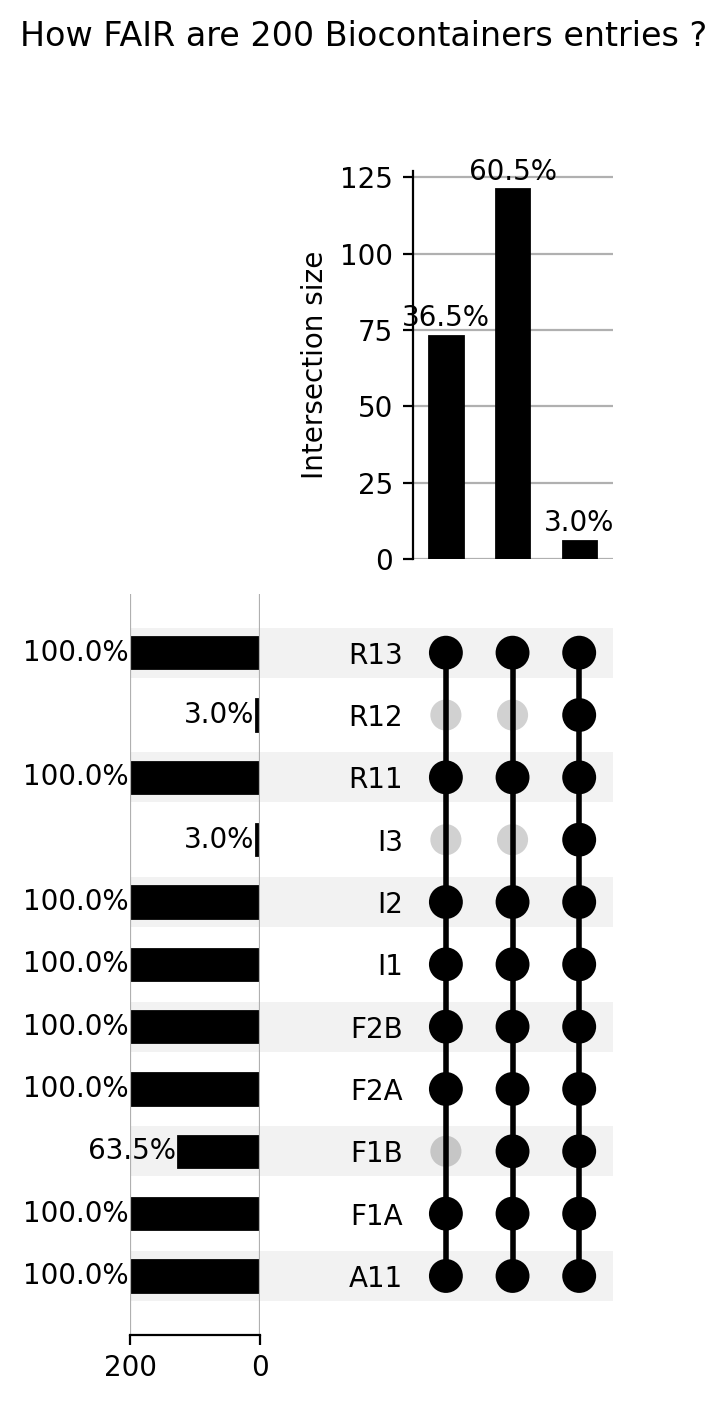

In [16]:
df_assessment = pd.read_csv("biocontainers_fair_assessment_results.csv")
df_upset = gen_df_upset_plot(df_assessment)
plot_upset(df_upset, data_source="Biocontainers", output_file="biocontainers_fair_assessment_upset.pdf")

In [8]:
urls = []
with open("bioconda_files.txt", "r") as f:
    for line in f:
        urls.append(line.strip())

#SAMPLE_SIZE = 10
#url_subset = urls[:SAMPLE_SIZE]

df_assessment = massive_fair_assessment(urls, output_file="biocontainers_fair_assessment_results.csv")


  0%|          | 0/1708 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
df_assessment = pd.read_csv("biotools_fair_assessment_results.csv")
df_upset = gen_df_upset_plot(df_assessment)
plot_upset(df_upset, data_source="Biotools", output_file="biotools_fair_assessment_upset.pdf")

NameError: name 'pd' is not defined

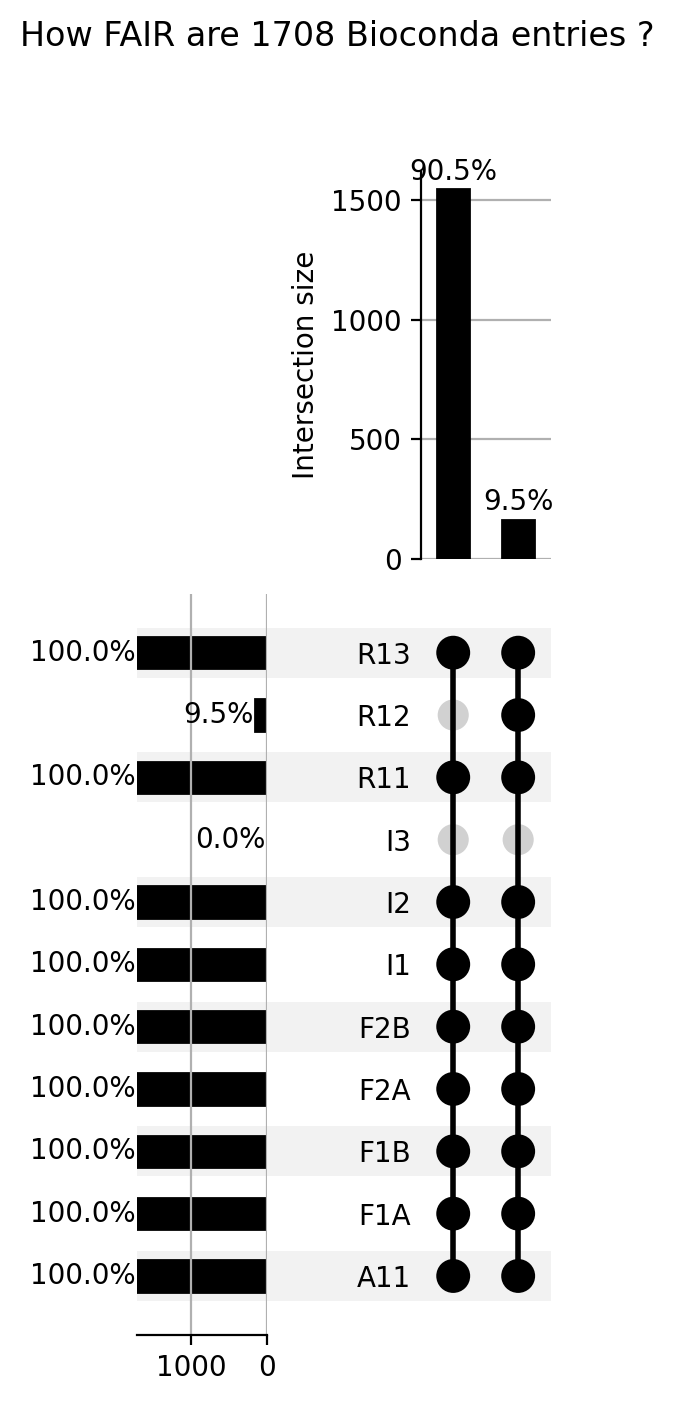

In [30]:
df_assessment = pd.read_csv("bioconda_fair_assessment_results.csv")
df_upset = gen_df_upset_plot(df_assessment)
plot_upset(df_upset, data_source="Bioconda", output_file="bioconda_fair_assessment_upset.pdf")

In [74]:
#print(rsec_urls[:5])  # Print the first 5 URLs as a sample output

# select 50 random URLs for testing
SAMPLE_SIZE = 50

#random.seed(42)  # For reproducibility
#URLS_subset = random.sample(rsec_urls, SAMPLE_SIZE)

URLS_subset = rsec_urls[:SAMPLE_SIZE]

# https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/1000genomes/1000genomes.bioschemas.jsonld

for i, u in enumerate(URLS_subset):   
    URLS_subset[i] = u.replace("../../content/data/", "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/")


# bioconda_sample_urls = [
#     "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/abricate/abricate.bioconda.jsonld", 
#     "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/abyss/abyss.bioconda.jsonld", 
#     "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/alfred/alfred.bioconda.jsonld", 
# ]

#biocontainers_sample_urls = [
#    "https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/abricate/abricate.biocontainers.jsonld", 
#]
 

FC_all_metrics_url = "https://fair-checker.france-bioinformatique.fr/api/check/legacy/metrics_all" 

df = pd.DataFrame()
rows = []

already_evaluated = pd.DataFrame()
if os.path.exists("biotools_fair_assessment_results.csv"):
    already_evaluated = pd.read_csv("biotools_fair_assessment_results.csv")
# if os.path.exists("bioconda_fair_assessment_results.csv"):
#     already_evaluated = pd.read_csv("bioconda_fair_assessment_results.csv")

for u in tqdm(URLS_subset):

    #print("Evaluating:", u)
    if len(already_evaluated) > 0 : 
        if u in already_evaluated["URL"].values:
            print("Already evaluated:", u)
            row = already_evaluated[already_evaluated["URL"] == u].to_dict(orient="records")[0]
            rows.append(row)
            continue

    start = time.time()
    res = requests.get(url=FC_all_metrics_url, params={"url": u})
    eval_in_sec = time.time() - start

    #print(res.status_code)
    #print(json.dumps(res.json(), indent=2))

    evaluations = res.json()
    row = {"URL": u}
    
    # iterating over all evaluation results
    for e in evaluations:
        row[e["metric"]] = int(e["score"])
    row["duration (s)"] = round(eval_in_sec, 2)
    print(row)
    rows.append(row)

from IPython.display import display, Markdown
df = pd.DataFrame.from_records(rows)
md = df.to_markdown()
display(Markdown(md))

df.to_csv("biotools_fair_assessment_results.csv", index=False)
#df.to_csv("bioconda_fair_assessment_results.csv", index=False)

  0%|          | 0/50 [00:00<?, ?it/s]

Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/culebront/culebront.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/gcmecm/gcmecm.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/modil/modil.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/rt_networks/rt_networks.bioschemas.jsonld
Already evaluated: https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/seqfeatr/seqfeatr.bioschemas.jsonld
{'URL': 'https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/mit_splice_predictor/mit_splice_predictor.bioschemas.jsonld', 'F1A': 2, 'F1B': 1, 'F2A': 1, 'F2B': 1, 'A1.1': 2, 'A1.2': 2, 'I1': 1, 'I2': 1, 'I3': 2, 'R1.1': 2, 'R1.2': 0, 'R1.3': 1, 'duration (s)': 2.09}
{'URL': 'https://git

|    | URL                                                                                                                                                                                                                   |   F1A |   F1B |   F2A |   F2B |   A1.1 |   A1.2 |   I1 |   I2 |   I3 |   R1.1 |   R1.2 |   R1.3 |   duration (s) |
|---:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------:|------:|------:|------:|-------:|-------:|-----:|-----:|-----:|-------:|-------:|-------:|---------------:|
|  0 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/culebront/culebront.bioschemas.jsonld                                                                                               |     2 |     0 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |          36.67 |
|  1 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/gcmecm/gcmecm.bioschemas.jsonld                                                                                                     |     2 |     1 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           7.15 |
|  2 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/modil/modil.bioschemas.jsonld                                                                                                       |     2 |     1 |     1 |     1 |      2 |      0 |    1 |    1 |    2 |      0 |      0 |      1 |           4.46 |
|  3 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/rt_networks/rt_networks.bioschemas.jsonld                                                                                           |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2    |
|  4 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/seqfeatr/seqfeatr.bioschemas.jsonld                                                                                                 |     2 |     1 |     1 |     1 |      2 |      2 |    1 |    1 |    2 |      2 |      0 |      1 |          10.21 |
|  5 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/mit_splice_predictor/mit_splice_predictor.bioschemas.jsonld                                                                         |     2 |     1 |     1 |     1 |      2 |      2 |    1 |    1 |    2 |      2 |      0 |      1 |           2.09 |
|  6 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/phynteny_transformer/phynteny_transformer.bioschemas.jsonld                                                                         |     2 |     0 |     1 |     2 |      2 |      0 |    1 |    2 |    0 |      0 |      0 |      2 |          32.22 |
|  7 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/snpspd/snpspd.bioschemas.jsonld                                                                                                     |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.18 |
|  8 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/forgi/forgi.bioschemas.jsonld                                                                                                       |     2 |     1 |     1 |     1 |      2 |      2 |    1 |    1 |    2 |      2 |      0 |      1 |           2.13 |
|  9 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/string/string.bioschemas.jsonld                                                                                                     |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      2 |      2 |           4.92 |
| 10 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/r-coffee/r-coffee.bioschemas.jsonld                                                                                                 |     2 |     1 |     1 |     1 |      2 |      0 |    1 |    1 |    2 |      0 |      0 |      1 |           2.08 |
| 11 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/tygs/tygs.bioschemas.jsonld                                                                                                         |     2 |     1 |     1 |     1 |      2 |      2 |    1 |    1 |    2 |      2 |      0 |      1 |           2.14 |
| 12 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/mtdfreml/mtdfreml.bioschemas.jsonld                                                                                                 |     2 |     0 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           2.08 |
| 13 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/siamprom/siamprom.bioschemas.jsonld                                                                                                 |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.1  |
| 14 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/d_skewness_f_minimum/d_skewness_f_minimum.bioschemas.jsonld                                                                         |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.15 |
| 15 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/delia/delia.bioschemas.jsonld                                                                                                       |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.15 |
| 16 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/seqminer-variant/seqminer-variant.bioschemas.jsonld                                                                                 |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.18 |
| 17 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/pointsite/pointsite.bioschemas.jsonld                                                                                               |     2 |     0 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.04 |
| 18 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/calculate-cycle-numbers-genetic-2-break-distance-problem/calculate-cycle-numbers-genetic-2-break-distance-problem.bioschemas.jsonld |     2 |     0 |     1 |     1 |      2 |      0 |    1 |    1 |    0 |      0 |      0 |      1 |           2.09 |
| 19 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/funcluster/funcluster.bioschemas.jsonld                                                                                             |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.1  |
| 20 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/novelseq/novelseq.bioschemas.jsonld                                                                                                 |     2 |     1 |     1 |     1 |      2 |      2 |    1 |    1 |    2 |      2 |      0 |      1 |           2.06 |
| 21 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/pycotools/pycotools.bioschemas.jsonld                                                                                               |     2 |     1 |     1 |     1 |      2 |      0 |    1 |    1 |    2 |      0 |      0 |      1 |           2.07 |
| 22 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/h-dbas/h-dbas.bioschemas.jsonld                                                                                                     |     2 |     1 |     1 |     1 |      2 |      0 |    1 |    1 |    2 |      0 |      0 |      1 |           2.1  |
| 23 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/spydrpick/spydrpick.bioschemas.jsonld                                                                                               |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.05 |
| 24 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/rprimer/rprimer.bioschemas.jsonld                                                                                                   |     2 |     1 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           2.05 |
| 25 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/kled/kled.bioschemas.jsonld                                                                                                         |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.18 |
| 26 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/loopgrafter/loopgrafter.bioschemas.jsonld                                                                                           |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.08 |
| 27 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/zinbwave/zinbwave.bioschemas.jsonld                                                                                                 |     2 |     0 |     1 |     1 |      2 |      2 |    1 |    1 |    2 |      2 |      0 |      1 |           2.28 |
| 28 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/cyclobranch/cyclobranch.bioschemas.jsonld                                                                                           |     2 |     1 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           2.05 |
| 29 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/deephage/deephage.bioschemas.jsonld                                                                                                 |     2 |     0 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           1.99 |
| 30 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/ac-caps/ac-caps.bioschemas.jsonld                                                                                                   |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.31 |
| 31 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/bastion6/bastion6.bioschemas.jsonld                                                                                                 |     2 |     1 |     1 |     1 |      2 |      0 |    1 |    1 |    2 |      0 |      0 |      1 |          44.33 |
| 32 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/pyseer/pyseer.bioschemas.jsonld                                                                                                     |     2 |     1 |     1 |     1 |      2 |      2 |    1 |    1 |    2 |      2 |      0 |      1 |           2.1  |
| 33 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/petitefinder/petitefinder.bioschemas.jsonld                                                                                         |     2 |     1 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           2.13 |
| 34 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/fragbuilder/fragbuilder.bioschemas.jsonld                                                                                           |     2 |     1 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           1.98 |
| 35 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/smallgenometools/smallgenometools.bioschemas.jsonld                                                                                 |     2 |     0 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.16 |
| 36 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/cfnet/cfnet.bioschemas.jsonld                                                                                                       |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.06 |
| 37 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/mistimm/mistimm.bioschemas.jsonld                                                                                                   |     2 |     1 |     1 |     1 |      2 |      2 |    1 |    1 |    2 |      2 |      0 |      1 |           2.13 |
| 38 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/goslin/goslin.bioschemas.jsonld                                                                                                     |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      2 |      2 |          15.94 |
| 39 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/exfi/exfi.bioschemas.jsonld                                                                                                         |     2 |     1 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           2.02 |
| 40 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/interactiontransformer/interactiontransformer.bioschemas.jsonld                                                                     |     2 |     0 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           2.14 |
| 41 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/structator/structator.bioschemas.jsonld                                                                                             |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.14 |
| 42 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/pemer/pemer.bioschemas.jsonld                                                                                                       |     2 |     1 |     1 |     1 |      2 |      0 |    1 |    1 |    2 |      0 |      0 |      1 |           1.97 |
| 43 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/ecmpy/ecmpy.bioschemas.jsonld                                                                                                       |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.03 |
| 44 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/biosigner/biosigner.bioschemas.jsonld                                                                                               |     2 |     1 |     1 |     1 |      2 |      2 |    1 |    1 |    2 |      2 |      0 |      1 |           2.05 |
| 45 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/phfinder/phfinder.bioschemas.jsonld                                                                                                 |     2 |     1 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           2.03 |
| 46 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/efetch_gene/efetch_gene.bioschemas.jsonld                                                                                           |     2 |     0 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.17 |
| 47 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/slhsd/slhsd.bioschemas.jsonld                                                                                                       |     2 |     1 |     1 |     2 |      2 |      2 |    1 |    2 |    2 |      2 |      0 |      2 |           2.04 |
| 48 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/flexynesis/flexynesis.bioschemas.jsonld                                                                                             |     2 |     0 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.07 |
| 49 | https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/hatseq/hatseq.bioschemas.jsonld                                                                                                     |     2 |     1 |     1 |     2 |      2 |      0 |    1 |    2 |    2 |      0 |      0 |      2 |           2.12 |

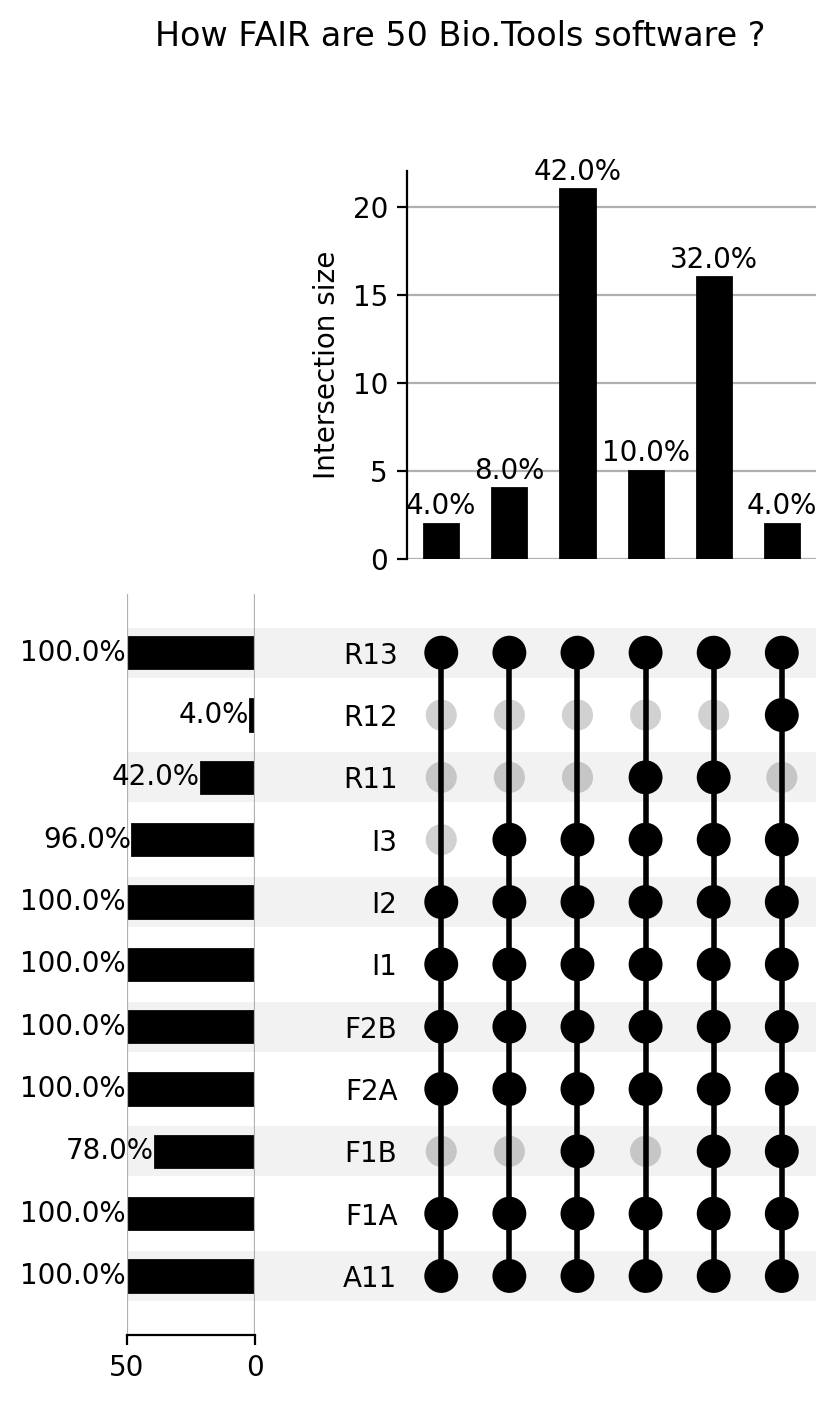

In [36]:
for r in df[df["R1.2"] > 0].itertuples():
    print(r)

Pandas(Index=9, URL='https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/string/string.bioschemas.jsonld', F1A=2, F1B=1, F2A=1, F2B=2, _6=2, _7=0, I1=1, I2=2, I3=2, _11=0, _12=2, _13=2, _14=6.1)
Pandas(Index=38, URL='https://github.com/research-software-ecosystem/content/raw/refs/heads/master/data/goslin/goslin.bioschemas.jsonld', F1A=2, F1B=1, F2A=1, F2B=2, _6=2, _7=0, I1=1, I2=2, I3=2, _11=0, _12=2, _13=2, _14=23.14)


In [ ]:
df 